<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Random Forest (RF) Modeling 
</p>

In [1]:
# Libraries for data manipulation and visualization
import numpy as np                               # For numerical operations
import pandas as pd                              # For data manipulation
import matplotlib.pyplot as plt                  # For plotting
import seaborn as sns                            # For advanced data visualization

# Libraries for model building and evaluation
from sklearn.ensemble import RandomForestRegressor  # For Random Forest Regression
from sklearn.metrics import (                     # For model evaluation metrics
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error, 
    median_absolute_error
)
from sklearn.model_selection import (              # For cross-validation, splitting data, and grid search
    KFold, 
    train_test_split, 
    GridSearchCV
)

# Set seed for reproducibility
np.random.seed(50)

In [2]:
# Define the path to the dataset
dataset_path = '../../all_data_files/cleaned_dataset_per_device.csv'

# Load the dataset
try:
    df = pd.read_csv(dataset_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found at the specified path: {dataset_path}")
    import sys
    sys.exit()

Dataset loaded successfully.

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607907 entries, 0 to 607906
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         607907 non-null  object 
 1   device_id    607907 non-null  object 
 2   co2          607907 non-null  float64
 3   humidity     607907 non-null  float64
 4   pm25         607907 non-null  float64
 5   pressure     607907 non-null  float64
 6   temperature  607907 non-null  float64
 7   rssi         607907 non-null  float64
 8   snr          607907 non-null  float64
 9   SF           607907 non-null  int64  
 10  frequency    607907 non-null  float64
 11  f_count      607907 non-null  float64
 12  p_count      607907 non-null  float64
 13  toa          607907 non-null  float64
 14  distance     607907 non-null  int64  
 15  c_walls      607907 non-null  int64  
 16  w_walls      607907 non-null  int64  
 17  exp_pl       607

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
0,2024-09-26 11:02:08.387851+00:00,ED0,539.0,49.34,0.39,299.69,24.57,-48.0,8.5,9,867.5,82.0,109.0,0.246784,10,0,0,65.4,-57.073822,-48.573822
1,2024-09-26 11:03:08.309590+00:00,ED0,540.0,49.33,0.80,299.77,24.59,-48.0,12.8,8,867.3,83.0,110.0,0.133632,10,0,0,65.4,-61.022142,-48.222142
2,2024-09-26 11:04:08.368448+00:00,ED0,537.0,49.28,0.71,299.70,24.62,-48.0,8.0,8,868.5,84.0,111.0,0.133632,10,0,0,65.4,-56.638920,-48.638920
3,2024-09-26 11:05:08.405529+00:00,ED0,537.0,49.34,0.56,299.69,24.63,-49.0,11.0,8,867.9,85.0,112.0,0.133632,10,0,0,66.4,-60.331956,-49.331956
4,2024-09-26 11:06:08.455112+00:00,ED0,534.0,49.28,0.60,299.73,24.64,-46.0,9.2,8,867.5,86.0,113.0,0.133632,10,0,0,63.4,-55.693058,-46.493058


In [3]:
# Define feature columns and target
feature_columns = [
    'distance', 'frequency', 'c_walls', 'w_walls', 
    'co2', 'humidity', 'pm25', 'pressure', 
    'temperature', 'snr'
]
target_column = 'exp_pl'

# Verify that all required columns exist
missing_columns = set(feature_columns + [target_column]) - set(df.columns)
if missing_columns:
    raise ValueError(f"The following required columns are missing in the dataset: {missing_columns}")

# Extract features and target
all_features = df[feature_columns].values
PL_all = df[target_column].values

# Perform train-test split (80-20 split)
X_train_all, X_test_all, PL_train_all, PL_test_all = train_test_split(
    all_features, PL_all, test_size=0.2, random_state=50
)

print("Train-test split completed.")

Train-test split completed.


In [4]:
# Define the fixed max_depth values
max_depth_values = [1, 2, 3]

# Define other hyperparameters for grid search
param_grid = {
    'n_estimators': [100, 200, 300],            # Number of trees in the forest
    'min_samples_split': [2, 10, 100],         # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]              # Minimum samples required at a leaf node
}

# Dictionary to store the best models for each max_depth
best_models = {}
best_params_per_depth = {}
best_scores_per_depth = {}

# Iterate over each max_depth and perform grid search
for depth in max_depth_values:
    print(f"\nPerforming Grid Search for max_depth={depth}...")
    
    # Create a base Random Forest Regressor with the current max_depth
    rf = RandomForestRegressor(
        max_depth=depth,
        criterion='squared_error',                # Fixed criterion
        max_features='log2',                      # Fixed max_features
        min_impurity_decrease=0.001,              # Fixed min_impurity_decrease
        random_state=50, 
        n_jobs=-1, 
        bootstrap=True, 
        oob_score=True
    )
    
    # Initialize Grid Search
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,                                       # 5-fold cross-validation
        scoring='neg_mean_squared_error',           # Using negative MSE for comparison
        verbose=1,
        n_jobs=-1
    )
    
    # Perform Grid Search
    grid_search.fit(X_train_all, PL_train_all)
    
    # Retrieve the best parameters and corresponding score
    best_params = grid_search.best_params_
    best_neg_mse = grid_search.best_score_
    best_mse = -best_neg_mse  # Convert from negative MSE to MSE
    
    best_models[depth] = grid_search.best_estimator_
    best_params_per_depth[depth] = best_params
    best_scores_per_depth[depth] = best_mse
    
    print(f"Best Parameters for max_depth={depth}: {best_params}")
    print(f"Best CV MSE for max_depth={depth}: {best_mse:.4f}")


Performing Grid Search for max_depth=1...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for max_depth=1: {'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best CV MSE for max_depth=1: 155.9194

Performing Grid Search for max_depth=2...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for max_depth=2: {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best CV MSE for max_depth=2: 79.8995

Performing Grid Search for max_depth=3...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for max_depth=3: {'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best CV MSE for max_depth=3: 52.0423


In [5]:
# Initialize a list to store evaluation metrics for each model
evaluation_metrics = []

for depth in max_depth_values:
    model = best_models[depth]
    params = best_params_per_depth[depth]
    
    print(f"\nEvaluating model with max_depth={depth} and parameters: {params}")
    
    # Train the model on the entire training set
    model.fit(X_train_all, PL_train_all)
    
    # Retrieve OOB score
    oob_score = model.oob_score_
    
    # Make predictions
    PL_train_pred = model.predict(X_train_all)
    PL_test_pred = model.predict(X_test_all)
    
    # Calculate metrics
    train_mse = mean_squared_error(PL_train_all, PL_train_pred)
    test_mse = mean_squared_error(PL_test_all, PL_test_pred)
    train_r2 = r2_score(PL_train_all, PL_train_pred)
    test_r2 = r2_score(PL_test_all, PL_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mape = mean_absolute_percentage_error(PL_test_all, PL_test_pred)
    test_median_ae = median_absolute_error(PL_test_all, PL_test_pred)
    
    # Append metrics to the list
    evaluation_metrics.append({
        'max_depth': depth,
        'OOB Score': oob_score,
        'Training Loss (MSE)': train_mse,
        'Test Loss (MSE)': test_mse,
        'Test RMSE': test_rmse,
        'R² Score': test_r2,
        'Test MAPE (%)': test_mape * 100,
        'Test Median AE': test_median_ae
    })
    
    print(f"Model with max_depth={depth} - OOB Score: {oob_score:.4f}")
    print(f"Training MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
    print(f"Training R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}, Test MAPE: {test_mape*100:.2f}%, Test Median AE: {test_median_ae:.4f}")
    
# Create a results DataFrame
results_df = pd.DataFrame(evaluation_metrics)

print("\nModel Evaluation Metrics for Best Models per max_depth:")
display(results_df)


Evaluating model with max_depth=1 and parameters: {'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Model with max_depth=1 - OOB Score: 0.5613
Training MSE: 157.9091, Test MSE: 157.8730
Training R²: 0.5641, Test R²: 0.5650
Test RMSE: 12.5648, Test MAPE: 11.23%, Test Median AE: 8.7132

Evaluating model with max_depth=2 and parameters: {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Model with max_depth=2 - OOB Score: 0.7754
Training MSE: 80.2529, Test MSE: 79.8427
Training R²: 0.7785, Test R²: 0.7800
Test RMSE: 8.9355, Test MAPE: 7.45%, Test Median AE: 5.4846

Evaluating model with max_depth=3 and parameters: {'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Model with max_depth=3 - OOB Score: 0.8563
Training MSE: 51.7583, Test MSE: 51.3957
Training R²: 0.8571, Test R²: 0.8584
Test RMSE: 7.1691, Test MAPE: 6.03%, Test Median AE: 4.4754

Model Evaluation Metrics for Best Models per max_depth:


,max_depth,OOB Score,Training Loss (MSE),Test Loss (MSE),Test RMSE,R² Score,Test MAPE (%),Test Median AE
0,1,0.561324,157.909123,157.873018,12.564753,0.564956,11.230336,8.713196
1,2,0.775406,80.252899,79.842749,8.935477,0.779980,7.451297,5.484565
2,3,0.856331,51.758274,51.395684,7.169078,0.858371,6.025713,4.475381


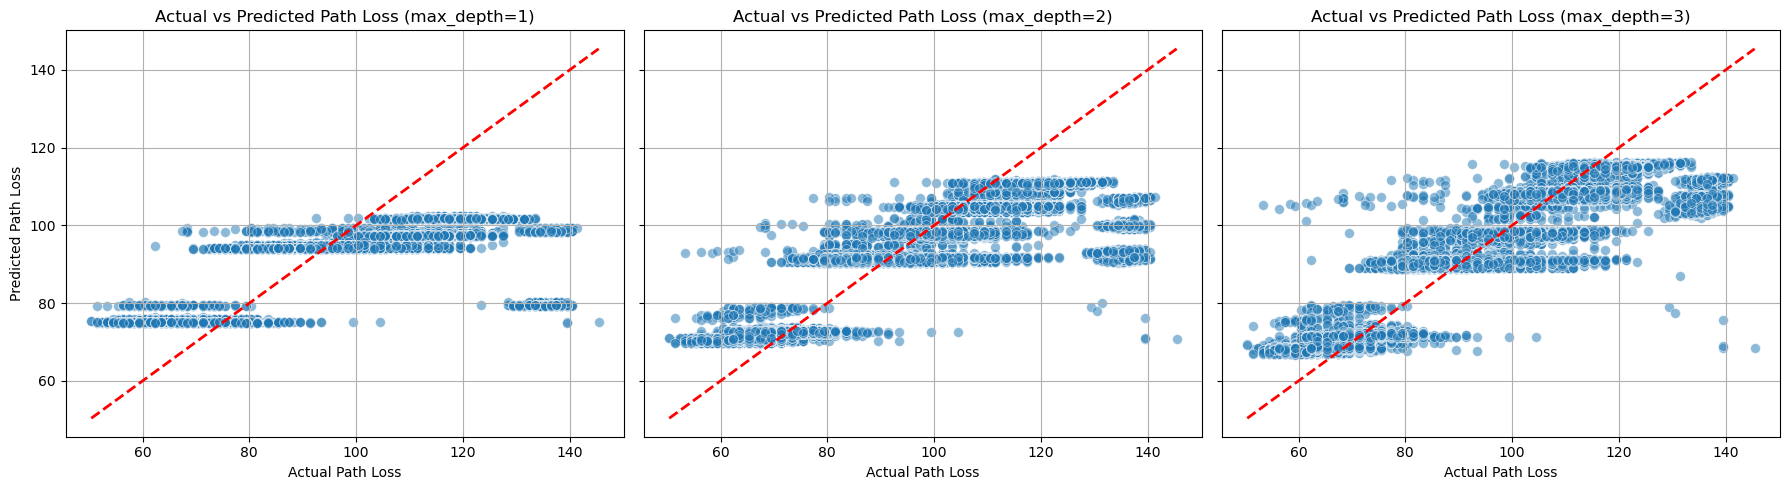

In [6]:
# Number of models
num_models = len(max_depth_values)

# Set up the subplot grid (1 row, 3 columns)
fig, axes = plt.subplots(1, num_models, figsize=(18, 5), sharey=True)

# If only one subplot, make axes iterable
if num_models == 1:
    axes = [axes]

for ax, depth in zip(axes, max_depth_values):
    model = best_models[depth]
    PL_test_pred = model.predict(X_test_all)
    
    sns.scatterplot(x=PL_test_all, y=PL_test_pred, alpha=0.5, edgecolor='w', s=50, ax=ax)
    ax.plot([PL_test_all.min(), PL_test_all.max()], [PL_test_all.min(), PL_test_all.max()], 'r--', lw=2)
    ax.set_xlabel('Actual Path Loss')
    ax.set_ylabel('Predicted Path Loss')
    ax.set_title(f'Actual vs Predicted Path Loss (max_depth={depth})')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [7]:
# Define the number of folds for cross-validation
n_folds = 5

# Initialize KFold
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Dictionary to store cross-validation results
cv_results_dict = {depth: [] for depth in max_depth_values}

print("\nPerforming K-Fold Cross-Validation for Each Best Model...\n")

for depth in max_depth_values:
    model = best_models[depth]
    params = best_params_per_depth[depth]
    
    print(f"Cross-Validation for max_depth={depth} with parameters: {params}")
    
    fold = 1
    for train_idx, val_idx in kf.split(X_train_all):
        
        # Split the data for the current fold
        X_train_fold, X_val_fold = X_train_all[train_idx], X_train_all[val_idx]
        PL_train_fold, PL_val_fold = PL_train_all[train_idx], PL_train_all[val_idx]
        
        # Instantiate a new model with the best parameters
        rf_cv = RandomForestRegressor(
            max_depth=depth,
            criterion='squared_error',                # Fixed criterion
            max_features='log2',                      # Fixed max_features
            min_impurity_decrease=0.001,              # Fixed min_impurity_decrease
            n_estimators=params['n_estimators'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            random_state=50, 
            n_jobs=-1, 
            bootstrap=True, 
            oob_score=True
        )
        
        # Train the model on the current fold
        rf_cv.fit(X_train_fold, PL_train_fold)
        
        # Predict on validation set
        PL_val_pred = rf_cv.predict(X_val_fold)
        
        # Calculate metrics
        val_mse = mean_squared_error(PL_val_fold, PL_val_pred)
        val_rmse = np.sqrt(val_mse)
        val_r2 = r2_score(PL_val_fold, PL_val_pred)
        val_mape = mean_absolute_percentage_error(PL_val_fold, PL_val_pred)
        val_median_ae = median_absolute_error(PL_val_fold, PL_val_pred)
        
        # Append metrics to the dictionary
        cv_results_dict[depth].append({
            'Fold': fold,
            'Validation Loss (MSE)': round(val_mse, 4),
            'Validation RMSE': round(val_rmse, 4),
            'R² Score': round(val_r2, 4),
            'Validation MAPE (%)': round(val_mape * 100, 2),
            'Validation Median AE': round(val_median_ae, 4)
        })
        
        print(f"    Fold {fold} - MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}, MAPE: {val_mape*100:.2f}%, Median AE: {val_median_ae:.4f}\n")
        fold += 1

# Create a DataFrame for each max_depth's CV results and display them
for depth in max_depth_values:
    print(f"\nK-Fold Cross-Validation Results for max_depth={depth}:")
    cv_results_df = pd.DataFrame(cv_results_dict[depth])
    display(cv_results_df)
    
    # Summary statistics
    cv_summary = cv_results_df.agg(['mean', 'std']).round(4).reset_index()
    cv_summary.rename(columns={'index': 'Metric'}, inplace=True)
    print(f"\nCross-Validation Summary for max_depth={depth}:")
    display(cv_summary)


Performing K-Fold Cross-Validation for Each Best Model...

Cross-Validation for max_depth=1 with parameters: {'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
  Training fold 1...
    Fold 1 - MSE: 156.7858, RMSE: 12.5214, R²: 0.5648, MAPE: 11.20%, Median AE: 8.7022

  Training fold 2...
    Fold 2 - MSE: 158.2582, RMSE: 12.5801, R²: 0.5629, MAPE: 11.19%, Median AE: 8.6853

  Training fold 3...
    Fold 3 - MSE: 158.5726, RMSE: 12.5926, R²: 0.5641, MAPE: 11.24%, Median AE: 8.6624

  Training fold 4...
    Fold 4 - MSE: 156.6960, RMSE: 12.5178, R²: 0.5666, MAPE: 11.23%, Median AE: 8.7229

  Training fold 5...
    Fold 5 - MSE: 159.1657, RMSE: 12.6161, R²: 0.5623, MAPE: 11.25%, Median AE: 8.7307

Cross-Validation for max_depth=2 with parameters: {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
  Training fold 1...
    Fold 1 - MSE: 79.8322, RMSE: 8.9349, R²: 0.7784, MAPE: 7.45%, Median AE: 5.4740

  Training fold 2...
    Fold 2 - MSE: 80.5167, RMS

,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,1,156.7858,12.5214,0.5648,11.20,8.7022
1,2,158.2582,12.5801,0.5629,11.19,8.6853
2,3,158.5726,12.5926,0.5641,11.24,8.6624
3,4,156.6960,12.5178,0.5666,11.23,8.7229
4,5,159.1657,12.6161,0.5623,11.25,8.7307



Cross-Validation Summary for max_depth=1:


,Metric,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,mean,3.0000,157.8957,12.5656,0.5641,11.2220,8.7007
1,std,1.5811,1.1038,0.0440,0.0017,0.0259,0.0278



K-Fold Cross-Validation Results for max_depth=2:


,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,1,79.8322,8.9349,0.7784,7.45,5.4740
1,2,80.5167,8.9731,0.7776,7.43,5.4861
2,3,80.7773,8.9876,0.7779,7.46,5.4916
3,4,79.3954,8.9104,0.7804,7.46,5.4969
4,5,80.9541,8.9975,0.7774,7.48,5.5287



Cross-Validation Summary for max_depth=2:


,Metric,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,mean,3.0000,80.2951,8.9607,0.7783,7.4560,5.4955
1,std,1.5811,0.6595,0.0368,0.0012,0.0182,0.0204



K-Fold Cross-Validation Results for max_depth=3:


,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,1,51.8625,7.2016,0.8561,6.04,4.4596
1,2,52.1597,7.2222,0.8559,6.04,4.4992
2,3,52.4023,7.2389,0.8559,6.04,4.4417
3,4,51.3009,7.1625,0.8581,6.03,4.5092
4,5,52.1595,7.2222,0.8566,6.05,4.5050



Cross-Validation Summary for max_depth=3:


,Metric,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,mean,3.0000,51.9770,7.2095,0.8565,6.0400,4.4829
1,std,1.5811,0.4236,0.0294,0.0009,0.0071,0.0304
